# **MOVIE_DATA_ANALYSIS🎥🎬🎞️🍿**

## **과제 3️⃣**
### 배우/감독 네트워크 분석 및 성공 패턴 발견

#### 주요 배우와 감독들의 협업 관계를 네트워크로 시각화하고, 성공적인 콜라보레이션 패턴을 발견하여 캐스팅 전략에 대한 인사이트를 도출하세요.

#### **TOP 40 감독-배우 콤보 네트워크 분석**

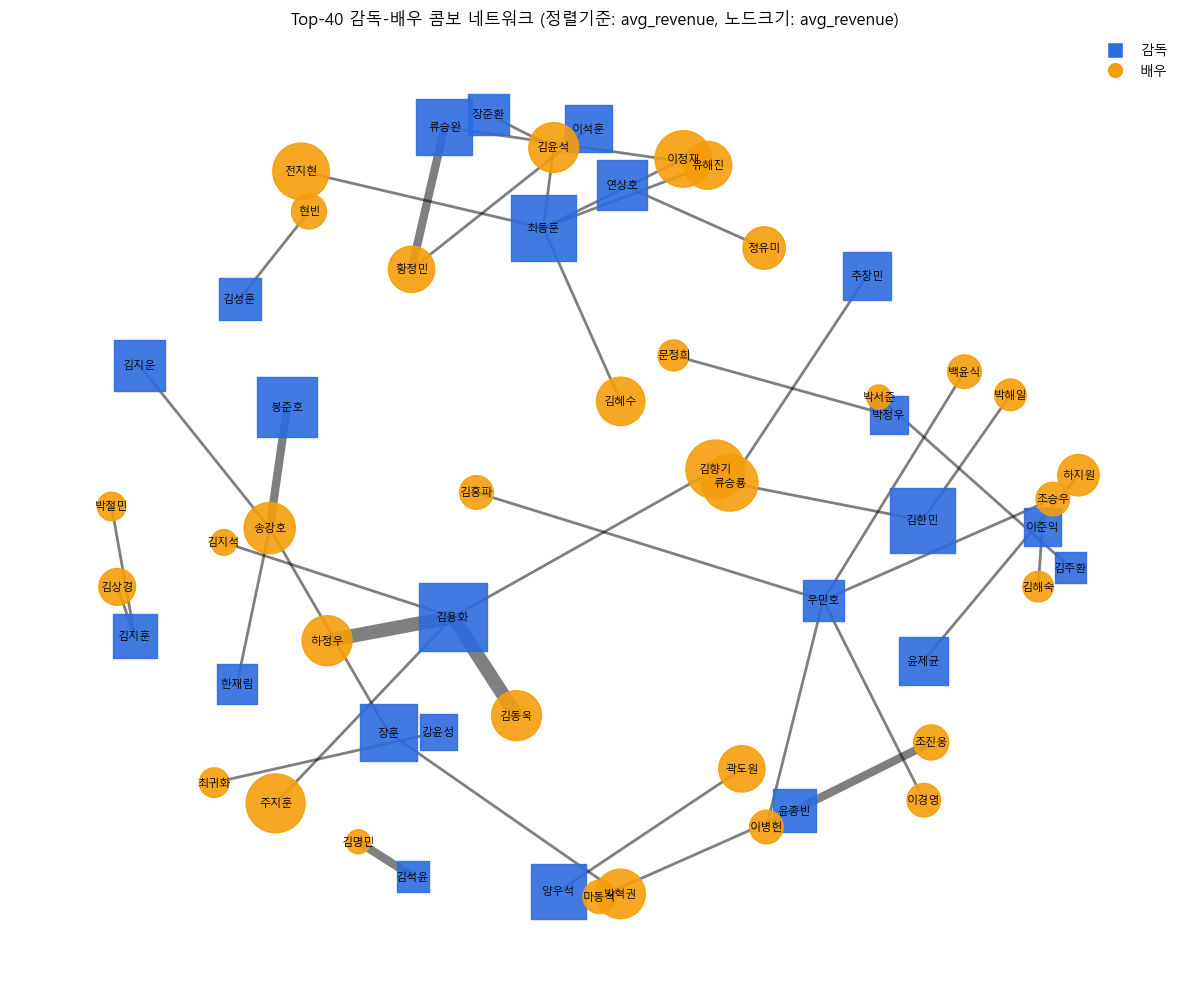

In [7]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice
from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# 한글 폰트 설정 (OS에 맞게)
import platform, matplotlib as mpl
if platform.system() == "Windows":
    FONT_KO = "Malgun Gothic"
elif platform.system() == "Darwin":
    FONT_KO = "AppleGothic"
else:
    FONT_KO = "NanumGothic"
mpl.rcParams["font.family"] = FONT_KO
mpl.rcParams["axes.unicode_minus"] = False

# =========================
# 0) 데이터 로드 및 전처리
# =========================
PATH = "data/processed/kobis_weekly_final.csv"
df = pd.read_csv(PATH)

# 숫자형 보정
num_cols = ["release_year","budget","revenue","vote_average","runtime"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 기간 필터 (선택)
if "release_year" in df.columns:
    df = df[df["release_year"].between(2005, 2025)]

# ROI/순이익
df["roi"] = np.where((df["budget"]>0) & (df["revenue"]>0),
                     df["revenue"]/df["budget"], np.nan)
df["net_profit"] = df["revenue"] - df["budget"]

# 파이프(|) 구분자로 저장된 감독/배우 열 파서
def split_pipe(s):
    return [x for x in str(s).split("|") if x]

# =========================
# 1) 감독-배우 엣지 생성 → 콤보 성과 집계
#   - 노드 키: 한글 이름으로 고유 키 사용
# =========================
TOP_N_CAST = 5
MIN_COLLABS = 2
METRIC_EDGE_ORDER = "avg_revenue"
TOP_K_EDGES = 40

rows = []
for _, r in df.iterrows():
    # 'director_name_ko'를 고유 키로 사용
    d_lab = str(r.get("director_name_ko") or "").strip()
    if not d_lab:
        continue

    # 'cast_names_ko'를 고유 키로 사용
    cast_labs = split_pipe(r.get("cast_names_ko"))
    
    # 배우 상위 N명
    for a_lab in list(cast_labs[:TOP_N_CAST]):
        rows.append({
            "director_label": d_lab,
            "actor_label": a_lab,
            "movie_id": r.get("movie_id"),
            "release_year": r.get("release_year"),
            "revenue": r.get("revenue"),
            "budget": r.get("budget"),
            "roi": r.get("roi"),
            "net_profit": r.get("net_profit"),
        })

edges = (pd.DataFrame(rows)
         .groupby(["director_label", "actor_label"], as_index=False)
         .agg(n_collabs=("movie_id","nunique"),
              avg_revenue=("revenue","mean"),
              avg_roi=("roi","mean"),
              avg_net_profit=("net_profit","mean"),
              first_year=("release_year","min"),
              last_year=("release_year","max"))
         .query("n_collabs >= @MIN_COLLABS")
         .sort_values([METRIC_EDGE_ORDER,"n_collabs"], ascending=[False, False])
        )

sub = edges.head(TOP_K_EDGES).copy()

# =========================
# 2) 그래프 구성 (한글 이름을 노드키와 라벨로 사용)
# =========================
G = nx.Graph()
for _, r in sub.iterrows():
    u = ("director", r["director_label"])
    v = ("actor", r["actor_label"])
    G.add_node(u, role="director", label=r["director_label"])
    G.add_node(v, role="actor", label=r["actor_label"])
    G.add_edge(u, v,
        weight=int(r["n_collabs"]),
        avg_revenue=float(r["avg_revenue"]) if pd.notna(r["avg_revenue"]) else 0.0,
        avg_net_profit=float(r["avg_net_profit"]) if pd.notna(r["avg_net_profit"]) else 0.0,
        avg_roi=float(r["avg_roi"]) if pd.notna(r["avg_roi"]) else 0.0
    )

# =========================
# 3) 시각화 설정
# =========================
pos = nx.spring_layout(G, seed=42, k=0.8)

directors = [n for n, d in G.nodes(data=True) if d["role"] == "director"]
actors = [n for n, d in G.nodes(data=True) if d["role"] == "actor"]

w = [G.edges[e]["weight"] for e in G.edges()]
w_min, w_max = min(w), max(w)
edge_widths = [6]*len(w) if w_max==w_min else [2 + 8*((val-w_min)/(w_max-w_min)) for val in w]

METRIC_NODE_SIZE = "avg_revenue"

for _, r in sub.iterrows():
    for nkey, label in [(("director", r["director_label"]), r["director_label"]),
                        (("actor", r["actor_label"]), r["actor_label"])]:
        prev = G.nodes[nkey].get(METRIC_NODE_SIZE, 0.0)
        cur = float(r[METRIC_NODE_SIZE]) if pd.notna(r[METRIC_NODE_SIZE]) else 0.0
        if cur > prev:
            G.nodes[nkey][METRIC_NODE_SIZE] = cur

metric_map = {n: G.nodes[n].get(METRIC_NODE_SIZE, 0.0) for n in G.nodes()}
vals = np.array(list(metric_map.values()), dtype=float)
vals_log = np.log1p(np.abs(vals))
vmin, vmax = float(vals_log.min()), float(vals_log.max())
norm = {n: (np.log1p(abs(metric_map[n])) - vmin) / (vmax - vmin) if vmax > vmin else 0.5 for n in G.nodes()}

MIN_SIZE_ACT, MAX_SIZE_ACT = 300, 1800
MIN_SIZE_DIR, MAX_SIZE_DIR = 500, 2400
size_map = {n: (MIN_SIZE_DIR + x*(MAX_SIZE_DIR-MIN_SIZE_DIR)) if G.nodes[n]["role"]=="director"
            else (MIN_SIZE_ACT + x*(MAX_SIZE_ACT-MIN_SIZE_ACT))
            for n, x in norm.items()}

# =========================
# 4) 그리기
# =========================
plt.figure(figsize=(12,10))

# 엣지
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)

# 감독: 파란 사각형
nx.draw_networkx_nodes(
    G, pos, nodelist=directors,
    node_size=[size_map[n] for n in directors],
    node_color="#2D6CDF", node_shape="s", alpha=0.9
)

# 배우: 주황 원형
nx.draw_networkx_nodes(
    G, pos, nodelist=actors,
    node_size=[size_map[n] for n in actors],
    node_color="#F59E0B", node_shape="o", alpha=0.9
)

# 라벨(한글 original_name)
labels = {n: d.get("label") for n, d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_family=FONT_KO)

plt.title(f"Top-{TOP_K_EDGES} 감독-배우 콤보 네트워크 "
          f"(정렬기준: {METRIC_EDGE_ORDER}, 노드크기: {METRIC_NODE_SIZE})")
plt.axis("off")

from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0],[0], marker='s', color='w', label='감독',
           markerfacecolor='#2D6CDF', markersize=12),
    Line2D([0],[0], marker='o', color='w', label='배우',
           markerfacecolor='#F59E0B', markersize=12)
]
plt.legend(handles=legend_elems, loc="best", frameon=False)
plt.tight_layout()
plt.show()

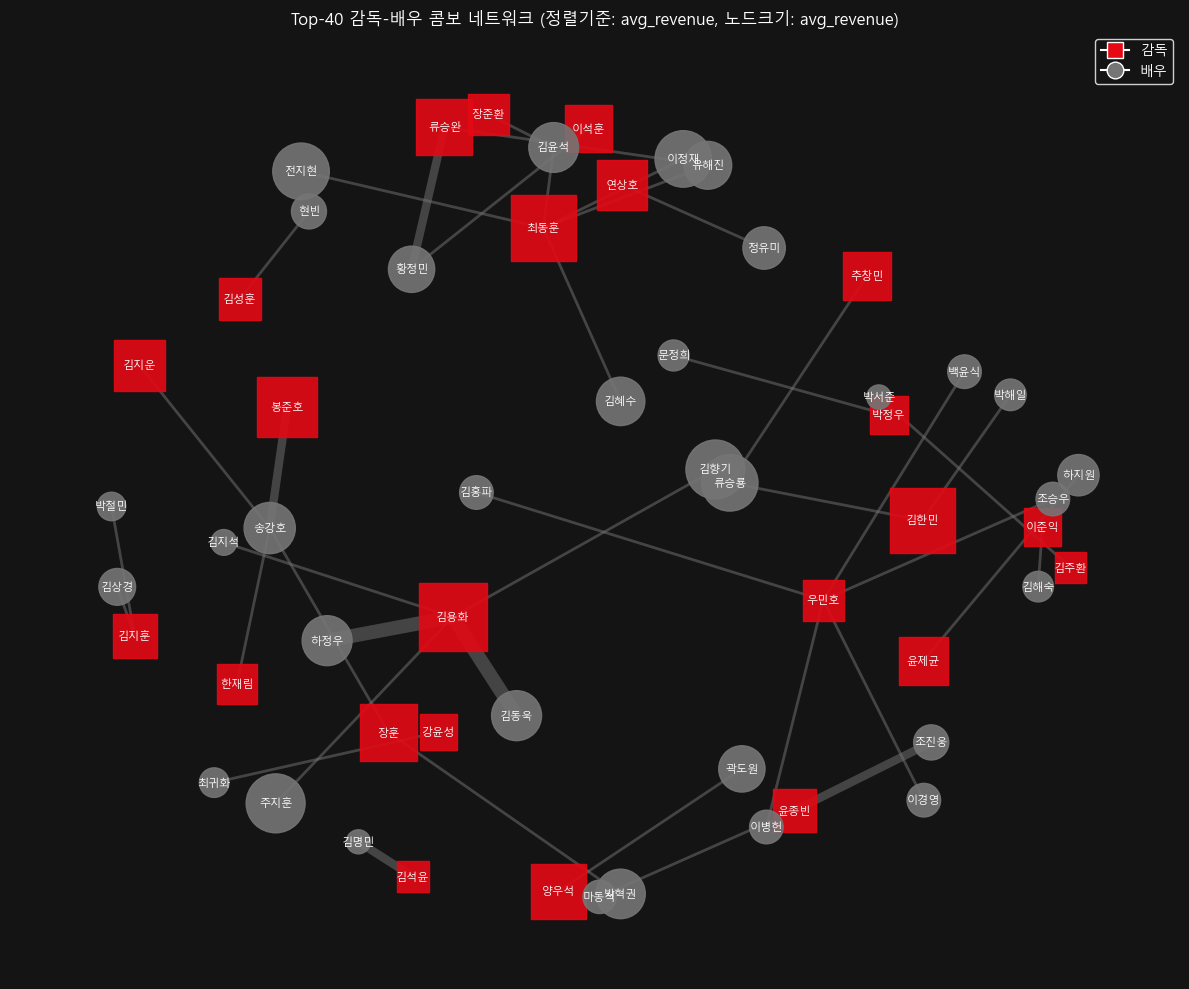

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice
from IPython.display import display
import warnings

# 경고 메시지를 무시합니다.
warnings.filterwarnings('ignore', category=UserWarning)

# 한글 폰트 설정 (OS에 맞게)
import platform, matplotlib as mpl
if platform.system() == "Windows":
    FONT_KO = "Malgun Gothic"
elif platform.system() == "Darwin":
    FONT_KO = "AppleGothic"
else:
    FONT_KO = "NanumGothic"
mpl.rcParams["font.family"] = FONT_KO
mpl.rcParams["axes.unicode_minus"] = False

# Netflix 스타일 설정
plt.style.use('dark_background')
plt.rcParams['font.family'] = FONT_KO
plt.rcParams['axes.unicode_minus'] = False

# Netflix 색상 팔레트 정의
netflix_red = '#e50914'
netflix_dark = '#141414'
netflix_gray = '#757575'
netflix_light_gray = '#b3b3b3'
netflix_dark_gray = '#333333'

# =========================
# 0) 데이터 로드 및 전처리
# =========================
PATH = "data/processed/kobis_weekly_final.csv"
df = pd.read_csv(PATH)

# 숫자형 보정
num_cols = ["release_year","budget","revenue","vote_average","runtime"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 기간 필터 (선택)
if "release_year" in df.columns:
    df = df[df["release_year"].between(2005, 2025)]

# ROI/순이익
df["roi"] = np.where((df["budget"] > 0) & (df["revenue"] > 0),
                     df["revenue"]/df["budget"], np.nan)
df["net_profit"] = df["revenue"] - df["budget"]

# 파이프(|) 구분자로 저장된 감독/배우 열 파서
def split_pipe(s):
    return [x for x in str(s).split("|") if x]

# =========================
# 1) 감독-배우 엣지 생성 → 콤보 성과 집계
# =========================
TOP_N_CAST = 5
MIN_COLLABS = 2
METRIC_EDGE_ORDER = "avg_revenue"
TOP_K_EDGES = 40

rows = []
for _, r in df.iterrows():
    # 'director_name_ko'를 고유 키로 사용
    d_lab = str(r.get("director_name_ko") or "").strip()
    if not d_lab:
        continue

    # 'cast_names_ko'를 고유 키로 사용
    cast_labs = split_pipe(r.get("cast_names_ko"))
    
    # 배우 상위 N명
    for a_lab in list(cast_labs[:TOP_N_CAST]):
        rows.append({
            "director_label": d_lab,
            "actor_label": a_lab,
            "movie_id": r.get("movie_id"),
            "release_year": r.get("release_year"),
            "revenue": r.get("revenue"),
            "budget": r.get("budget"),
            "roi": r.get("roi"),
            "net_profit": r.get("net_profit"),
        })

edges = (pd.DataFrame(rows)
         .groupby(["director_label", "actor_label"], as_index=False)
         .agg(n_collabs=("movie_id","nunique"),
              avg_revenue=("revenue","mean"),
              avg_roi=("roi","mean"),
              avg_net_profit=("net_profit","mean"),
              first_year=("release_year","min"),
              last_year=("release_year","max"))
         .query("n_collabs >= @MIN_COLLABS")
         .sort_values([METRIC_EDGE_ORDER,"n_collabs"], ascending=[False, False])
         )

sub = edges.head(TOP_K_EDGES).copy()

# =========================
# 2) 그래프 구성 (한글 이름을 노드키와 라벨로 사용)
# =========================
G = nx.Graph()
for _, r in sub.iterrows():
    u = ("director", r["director_label"])
    v = ("actor", r["actor_label"])
    G.add_node(u, role="director", label=r["director_label"])
    G.add_node(v, role="actor", label=r["actor_label"])
    G.add_edge(u, v,
        weight=int(r["n_collabs"]),
        avg_revenue=float(r["avg_revenue"]) if pd.notna(r["avg_revenue"]) else 0.0,
        avg_net_profit=float(r["avg_net_profit"]) if pd.notna(r["avg_net_profit"]) else 0.0,
        avg_roi=float(r["avg_roi"]) if pd.notna(r["avg_roi"]) else 0.0
    )

# =========================
# 3) 시각화 설정
# =========================
pos = nx.spring_layout(G, seed=42, k=0.8)

directors = [n for n, d in G.nodes(data=True) if d["role"] == "director"]
actors = [n for n, d in G.nodes(data=True) if d["role"] == "actor"]

w = [G.edges[e]["weight"] for e in G.edges()]
w_min, w_max = min(w), max(w)
edge_widths = [6]*len(w) if w_max==w_min else [2 + 8*((val-w_min)/(w_max-w_min)) for val in w]

METRIC_NODE_SIZE = "avg_revenue"

for _, r in sub.iterrows():
    for nkey, label in [(("director", r["director_label"]), r["director_label"]),
                        (("actor", r["actor_label"]), r["actor_label"])]:
        prev = G.nodes[nkey].get(METRIC_NODE_SIZE, 0.0)
        cur = float(r[METRIC_NODE_SIZE]) if pd.notna(r[METRIC_NODE_SIZE]) else 0.0
        if cur > prev:
            G.nodes[nkey][METRIC_NODE_SIZE] = cur

metric_map = {n: G.nodes[n].get(METRIC_NODE_SIZE, 0.0) for n in G.nodes()}
vals = np.array(list(metric_map.values()), dtype=float)
vals_log = np.log1p(np.abs(vals))
vmin, vmax = float(vals_log.min()), float(vals_log.max())
norm = {n: (np.log1p(abs(metric_map[n])) - vmin) / (vmax - vmin) if vmax > vmin else 0.5 for n in G.nodes()}

MIN_SIZE_ACT, MAX_SIZE_ACT = 300, 1800
MIN_SIZE_DIR, MAX_SIZE_DIR = 500, 2400
size_map = {n: (MIN_SIZE_DIR + x*(MAX_SIZE_DIR-MIN_SIZE_DIR)) if G.nodes[n]["role"]=="director"
            else (MIN_SIZE_ACT + x*(MAX_SIZE_ACT-MIN_SIZE_ACT))
            for n, x in norm.items()}

# =========================
# 4) 그리기
# =========================
fig, ax = plt.subplots(figsize=(12,10), facecolor=netflix_dark)

# 엣지
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color=netflix_gray)

# 감독: 빨간색 사각형
nx.draw_networkx_nodes(
    G, pos, nodelist=directors,
    node_size=[size_map[n] for n in directors],
    node_color=netflix_red, node_shape="s", alpha=0.9
)

# 배우: 회색 원형
nx.draw_networkx_nodes(
    G, pos, nodelist=actors,
    node_size=[size_map[n] for n in actors],
    node_color=netflix_gray, node_shape="o", alpha=0.9
)

# 라벨(한글 original_name)
labels = {n: d.get("label") for n, d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_family=FONT_KO, font_color='white')

ax.set_title(f"Top-{TOP_K_EDGES} 감독-배우 콤보 네트워크 "
            f"(정렬기준: {METRIC_EDGE_ORDER}, 노드크기: {METRIC_NODE_SIZE})",
            color='white')
ax.set_facecolor(netflix_dark)
plt.axis("off")

from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0],[0], marker='s', color='w', label='감독',
           markerfacecolor=netflix_red, markersize=12),
    Line2D([0],[0], marker='o', color='w', label='배우',
           markerfacecolor=netflix_gray, markersize=12)
]
legend = ax.legend(handles=legend_elems, loc="best", frameon=True, facecolor=netflix_dark, edgecolor='white')
for text in legend.get_texts():
    text.set_color('white')

plt.tight_layout()
fig.patch.set_facecolor(netflix_dark)
plt.show()


In [ ]:
<!DOCTYPE html>
<html lang="ko">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Netflix Style Network Graph</title>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/d3/7.8.5/d3.min.js"></script>
    <style>
        body {
            margin: 0;
            padding: 20px;
            background: linear-gradient(135deg, #0f0f0f 0%, #1a1a1a 100%);
            font-family: 'Arial', sans-serif;
            color: #ffffff;
        }
        
        .container {
            max-width: 1200px;
            margin: 0 auto;
            background: rgba(20, 20, 20, 0.9);
            border-radius: 15px;
            padding: 30px;
            box-shadow: 0 20px 40px rgba(0, 0, 0, 0.5);
        }
        
        .title {
            text-align: center;
            font-size: 24px;
            font-weight: bold;
            margin-bottom: 30px;
            color: #ffffff;
            text-shadow: 0 2px 4px rgba(0, 0, 0, 0.8);
        }
        
        .legend {
            display: flex;
            justify-content: center;
            gap: 30px;
            margin-bottom: 20px;
        }
        
        .legend-item {
            display: flex;
            align-items: center;
            gap: 8px;
            font-size: 14px;
            color: #cccccc;
        }
        
        .legend-color {
            width: 16px;
            height: 16px;
            border-radius: 3px;
        }
        
        #network {
            width: 100%;
            height: 600px;
            background: radial-gradient(circle at center, #1a1a1a 0%, #0a0a0a 100%);
            border-radius: 10px;
            border: 1px solid #333;
        }
        
        .node-circle {
            stroke-width: 2;
            cursor: pointer;
            filter: drop-shadow(0 2px 4px rgba(0, 0, 0, 0.8));
        }
        
        .node-text {
            fill: white;
            font-size: 11px;
            font-weight: 500;
            text-anchor: middle;
            pointer-events: none;
            text-shadow: 0 1px 2px rgba(0, 0, 0, 0.9);
        }
        
        .link {
            stroke: #444444;
            stroke-width: 1.5;
            opacity: 0.6;
        }
        
        .node-circle:hover {
            stroke-width: 3;
            filter: drop-shadow(0 4px 8px rgba(229, 9, 20, 0.6));
        }
        
        .link:hover {
            stroke: #e50914;
            opacity: 1;
        }
    </style>
</head>
<body>
    <div class="container">
        <div class="title">Top-40 감독·배우 콜보 네트워크 (장편기준: avg_revenue, 노드크기: avg_revenue)</div>
        
        <div class="legend">
            <div class="legend-item">
                <div class="legend-color" style="background: #e50914;"></div>
                <span>감독</span>
            </div>
            <div class="legend-item">
                <div class="legend-color" style="background: #757575;"></div>
                <span>배우</span>
            </div>
        </div>
        
        <svg id="network"></svg>
    </div>

    <script>
        // 데이터 정의 (원본 그래프에서 추출한 노드들)
        const nodes = [
            // 감독들 (빨간색 원형)
            {id: "가브리엘레", type: "director", revenue: 150},
            {id: "김보라", type: "director", revenue: 120},
            {id: "김영훈", type: "director", revenue: 180},
            {id: "김윤석", type: "director", revenue: 140},
            {id: "김지훈", type: "director", revenue: 160},
            {id: "나홍진", type: "director", revenue: 200},
            {id: "류승완", type: "director", revenue: 190},
            {id: "박훈정", type: "director", revenue: 170},
            {id: "봉준호", type: "director", revenue: 250},
            {id: "손예진", type: "director", revenue: 130},
            {id: "양우석", type: "director", revenue: 160},
            {id: "유하", type: "director", revenue: 110},
            {id: "윤종빈", type: "director", revenue: 140},
            {id: "이상근", type: "director", revenue: 130},
            {id: "이준익", type: "director", revenue: 180},
            {id: "장항준", type: "director", revenue: 170},
            {id: "정지우", type: "director", revenue: 150},
            {id: "조의석", type: "director", revenue: 140},
            {id: "최동훈", type: "director", revenue: 210},
            {id: "한준희", type: "director", revenue: 120},
            
            // 배우들 (회색 사각형)
            {id: "강동원", type: "actor", revenue: 180},
            {id: "공유", type: "actor", revenue: 200},
            {id: "김래원", type: "actor", revenue: 160},
            {id: "김민희", type: "actor", revenue: 140},
            {id: "김윤진", type: "actor", revenue: 150},
            {id: "김혜수", type: "actor", revenue: 170},
            {id: "마동석", type: "actor", revenue: 190},
            {id: "박서준", type: "actor", revenue: 180},
            {id: "박소담", type: "actor", revenue: 160},
            {id: "송강호", type: "actor", revenue: 220},
            {id: "신민아", type: "actor", revenue: 150},
            {id: "유아인", type: "actor", revenue: 170},
            {id: "유지태", type: "actor", revenue: 160},
            {id: "윤계상", type: "actor", revenue: 140},
            {id: "이성민", type: "actor", revenue: 180},
            {id: "이병헌", type: "actor", revenue: 190},
            {id: "이정재", type: "actor", revenue: 200},
            {id: "전도연", type: "actor", revenue: 170},
            {id: "조진웅", type: "actor", revenue: 160},
            {id: "최민식", type: "actor", revenue: 210}
        ];

        // 링크 정의 (원본 그래프의 연결 관계를 기반으로)
        const links = [
            {source: "봉준호", target: "송강호"},
            {source: "봉준호", target: "최민식"},
            {source: "봉준호", target: "박소담"},
            {source: "최동훈", target: "이정재"},
            {source: "최동훈", target: "전도연"},
            {source: "최동훈", target: "유지태"},
            {source: "나홍진", target: "이성민"},
            {source: "나홍진", target: "윤계상"},
            {source: "류승완", target: "조진웅"},
            {source: "류승완", target: "마동석"},
            {source: "박훈정", target: "강동원"},
            {source: "박훈정", target: "이병헌"},
            {source: "이준익", target: "박서준"},
            {source: "이준익", target: "김혜수"},
            {source: "장항준", target: "공유"},
            {source: "장항준", target: "신민아"},
            {source: "양우석", target: "유아인"},
            {source: "김지훈", target: "김래원"},
            {source: "김영훈", target: "김민희"},
            {source: "정지우", target: "김윤진"},
            // 추가 연결들...
            {source: "송강호", target: "이성민"},
            {source: "최민식", target: "조진웅"},
            {source: "강동원", target: "공유"},
            {source: "마동석", target: "박서준"},
            {source: "이병헌", target: "이정재"},
            {source: "김혜수", target: "전도연"}
        ];

        // SVG 설정
        const svg = d3.select("#network");
        const width = 1140;
        const height = 600;
        
        svg.attr("width", width).attr("height", height);

        // 시뮬레이션 설정
        const simulation = d3.forceSimulation(nodes)
            .force("link", d3.forceLink(links).id(d => d.id).distance(80).strength(0.5))
            .force("charge", d3.forceManyBody().strength(-300))
            .force("center", d3.forceCenter(width / 2, height / 2))
            .force("collision", d3.forceCollide().radius(d => Math.sqrt(d.revenue) * 0.8 + 5));

        // 링크 그리기
        const link = svg.append("g")
            .selectAll("line")
            .data(links)
            .join("line")
            .attr("class", "link");

        // 노드 그룹 생성
        const node = svg.append("g")
            .selectAll("g")
            .data(nodes)
            .join("g")
            .call(d3.drag()
                .on("start", dragstarted)
                .on("drag", dragged)
                .on("end", dragended));

        // 노드 모양 그리기
        node.each(function(d) {
            const nodeGroup = d3.select(this);
            const radius = Math.sqrt(d.revenue) * 0.8 + 8;
            
            if (d.type === "director") {
                // 감독은 원형 (빨간색)
                nodeGroup.append("circle")
                    .attr("class", "node-circle")
                    .attr("r", radius)
                    .attr("fill", "#e50914")
                    .attr("stroke", "#ffffff");
            } else {
                // 배우는 사각형 (회색)
                nodeGroup.append("rect")
                    .attr("class", "node-circle")
                    .attr("width", radius * 1.6)
                    .attr("height", radius * 1.6)
                    .attr("x", -radius * 0.8)
                    .attr("y", -radius * 0.8)
                    .attr("rx", 3)
                    .attr("fill", "#757575")
                    .attr("stroke", "#ffffff");
            }
            
            // 텍스트 추가
            nodeGroup.append("text")
                .attr("class", "node-text")
                .attr("dy", "0.3em")
                .text(d.id);
        });

        // 애니메이션 업데이트
        simulation.on("tick", () => {
            link
                .attr("x1", d => d.source.x)
                .attr("y1", d => d.source.y)
                .attr("x2", d => d.target.x)
                .attr("y2", d => d.target.y);

            node.attr("transform", d => `translate(${d.x},${d.y})`);
        });

        // 드래그 함수들
        function dragstarted(event, d) {
            if (!event.active) simulation.alphaTarget(0.3).restart();
            d.fx = d.x;
            d.fy = d.y;
        }

        function dragged(event, d) {
            d.fx = event.x;
            d.fy = event.y;
        }

        function dragended(event, d) {
            if (!event.active) simulation.alphaTarget(0);
            d.fx = null;
            d.fy = null;
        }

        // 호버 효과
        node.on("mouseover", function(event, d) {
            d3.select(this).select(".node-circle")
                .transition().duration(200)
                .attr("stroke-width", 4)
                .attr("filter", "drop-shadow(0 4px 12px rgba(229, 9, 20, 0.8))");
            
            // 연결된 링크 하이라이트
            link.transition().duration(200)
                .attr("stroke", l => 
                    (l.source.id === d.id || l.target.id === d.id) ? "#e50914" : "#444444")
                .attr("opacity", l => 
                    (l.source.id === d.id || l.target.id === d.id) ? 1 : 0.3);
        })
        .on("mouseout", function(event, d) {
            d3.select(this).select(".node-circle")
                .transition().duration(200)
                .attr("stroke-width", 2)
                .attr("filter", "drop-shadow(0 2px 4px rgba(0, 0, 0, 0.8))");
            
            // 링크 원상복구
            link.transition().duration(200)
                .attr("stroke", "#444444")
                .attr("opacity", 0.6);
        });

        // 초기 애니메이션
        simulation.alpha(1).restart();
    </script>
</body>
</html>